In [1]:
import os
import sys
import json
import boto3
import logging
import psycopg2
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, struct, countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()
conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '12G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st112143/


In [3]:
k8s = pd.read_csv('kubernetes_events.csv',  sep=';')

In [4]:
k8s

,time_stamp,stream,kubernetes_host,kubernetes_pod_name,verb,event_uid,event_creation_timestamp,event_name,event_namespace,involved_object_kind,involved_object_namespace,involved_object_name,event_reason,event_message
0,2023-09-27 09:26:36.532341,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,c9a5ed86-614e-4259-9a31-0abd21af3baf,2023-09-20 21:16:28,claim-st082199.1786b7f8b8079bcc,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1,2023-09-27 09:26:36.546469,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,1dea347c-347e-41e5-a6d3-4892753761a0,2023-09-20 21:16:28,claim-st097893.1786b7f8baa03370,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
2,2023-09-27 09:30:50.184708,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,cce2716b-37d0-4753-a1a3-fe4cc1d251c4,2023-09-27 08:30:33,continuous-image-puller-4vqk2.1788b43cea1c5007,jhub,Pod,jhub,continuous-image-puller-4vqk2,Pulled,"Container image ""cr.yandex/crptfs8246iv37ojkor..."
3,2023-09-27 09:30:50.184766,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,a83988f4-bbc9-4269-bb8d-98e09570d474,2023-09-27 08:30:35,continuous-image-puller-4vqk2.1788b43d740ba60c,jhub,Pod,jhub,continuous-image-puller-4vqk2,Started,Started container image-pull-singleuser-profil...
4,2023-09-27 09:30:50.184828,stderr,cl1llpobhs2ijlf53v62-imaj,eventrouter-5874bd6747-dwfj4,UPDATED,ec5b8523-c890-460a-907c-f7ee41a3f625,2023-09-27 08:30:40,continuous-image-puller-zczf4.1788b43e92174a29,jhub,Pod,jhub,continuous-image-puller-zczf4,Pulled,"Container image ""jupyterhub/k8s-network-tools:..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007357,2023-11-18 21:36:54.360190,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007358,2023-11-18 21:40:51.964239,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,06aec7f7-e6e9-4eb6-aeec-a86b2d71859f,2023-11-10 10:00:44,claim-st082199.17963ab1ababb2c3,jhub,PersistentVolumeClaim,jhub,claim-st082199,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007359,2023-11-18 21:40:51.983044,stderr,cl1llpobhs2ijlf53v62-aluf,eventrouter-5874bd6747-fqvfz,UPDATED,1980f051-bb34-4d9c-8004-871a98feb253,2023-11-10 10:00:44,claim-st097893.17963ab1af9b625f,jhub,PersistentVolumeClaim,jhub,claim-st097893,WaitForFirstConsumer,waiting for first consumer to be created befor...
1007360,2023-03-09 15:14:41.173970,stderr,cl1flrrk4hvdbm084md4-elef,eventrouter-5874bd6747-nfbjv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
logs = pd.read_csv('jhub_logs.csv',  sep=';')

In [6]:
logs

,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg
0,2023-04-06 13:40:43.589082,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.588,JupyterHub,log,181.0,302 GET /user/st095441/api/contents/__VK/model...
1,2023-04-06 13:40:43.619658,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.619,JupyterHub,log,181.0,302 GET /hub/user/st095441/api/contents/__VK/m...
2,2023-04-06 13:40:43.653159,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.652,JupyterHub,log,181.0,200 GET /hub/login?next=%2Fhub%2Fuser%2Fst0954...
3,2023-04-06 13:40:43.793204,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,W,2023-04-06 13:40:43.792,JupyterHub,log,181.0,405 PUT /user/st095441/api/contents/__VK/model...
4,2023-04-06 13:40:56.665458,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:56.664,JupyterHub,proxy,319.0,Checking routes
...,...,...,...,...,...,...,...,...,...,...
4575910,2023-10-20 09:53:50.954623,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-l7mw5,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575911,2023-10-20 10:22:49.850447,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-nnkkp,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575912,2023-10-23 05:01:12.068719,git-clone-templates,cl1llpobhs2ijlf53v62-aluf,hub-f747d85cf-p9qf6,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n
4575913,2023-10-23 18:23:21.728021,git-clone-templates,cl1llpobhs2ijlf53v62-obin,hub-f747d85cf-pn8r7,NaN,NaN,NaN,NaN,NaN,Cloning into '/etc/jupyterhub/custom'...\n


In [7]:
logs = logs.dropna()
logs

,time_stamp,kuber_container_name,kuber_host,kuber_pod_name,log_head,log_timestamp,log_service,log_type,log_code,log_msg
0,2023-04-06 13:40:43.589082,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.588,JupyterHub,log,181.0,302 GET /user/st095441/api/contents/__VK/model...
1,2023-04-06 13:40:43.619658,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.619,JupyterHub,log,181.0,302 GET /hub/user/st095441/api/contents/__VK/m...
2,2023-04-06 13:40:43.653159,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:43.652,JupyterHub,log,181.0,200 GET /hub/login?next=%2Fhub%2Fuser%2Fst0954...
3,2023-04-06 13:40:43.793204,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,W,2023-04-06 13:40:43.792,JupyterHub,log,181.0,405 PUT /user/st095441/api/contents/__VK/model...
4,2023-04-06 13:40:56.665458,hub,cl1flrrk4hvdbm084md4-elef,hub-57c88d997b-xh654,I,2023-04-06 13:40:56.664,JupyterHub,proxy,319.0,Checking routes
...,...,...,...,...,...,...,...,...,...,...
4575851,2023-08-03 02:15:54.233354,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 02:15:54.233,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575852,2023-08-03 06:18:17.779582,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 06:18:17.779,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575853,2023-08-03 07:58:30.291657,hub,cl1llpobhs2ijlf53v62-yjof,hub-77d4b9fbd-9hrmk,I,2023-08-03 07:58:30.291,JupyterHub,log,186.0,200 POST /hub/api/users/st067810/activity (st0...
4575878,2023-06-28 09:16:57.429715,hub,cl1llpobhs2ijlf53v62-anes,hub-557fbb85c-8nkl4,I,2023-06-28 09:16:57.429,JupyterHub,log,181.0,200 POST /hub/api/users/vgarshin/activity (vga...


In [8]:
start_times = logs[logs['log_msg'].str.contains("start", na=False)].copy()
start_times['start_duration'] = start_times['log_msg'].str.extract(r'took (\d+\.\d+) seconds').astype(float)

In [9]:
print(start_times['start_duration'].describe())

count    11300.000000
mean        54.591695
std         80.060768
min          8.227000
25%         22.810000
50%         25.025500
75%         36.503000
max        599.150000
Name: start_duration, dtype: float64


In [10]:
start_times['time_stamp'] = pd.to_datetime(start_times['time_stamp'], errors='coerce')
start_times['date'] = start_times['time_stamp'].dt.date

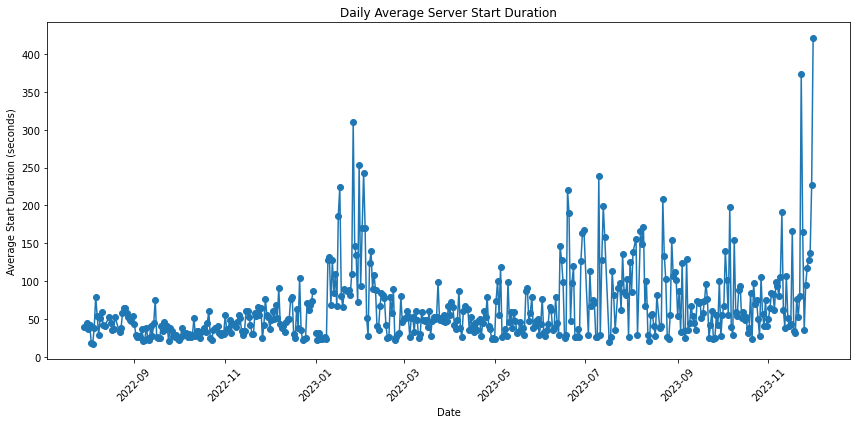

In [11]:
# Group by the new 'date' column and calculate the mean start_duration for each date
daily_avg_start = start_times.groupby('date')['start_duration'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_avg_start['date'], daily_avg_start['start_duration'], marker='o')
plt.title('Daily Average Server Start Duration')
plt.xlabel('Date')
plt.ylabel('Average Start Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

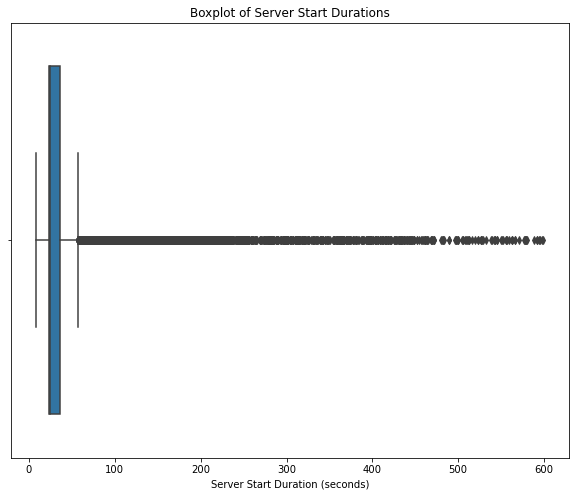

In [12]:
plt.figure(figsize=(10, 8))
sns.boxplot(x=start_times['start_duration'])
plt.title('Boxplot of Server Start Durations')
plt.xlabel('Server Start Duration (seconds)')
plt.show()

In [13]:
threshold = daily_avg_start['start_duration'].quantile(0.95)
outliers = daily_avg_start[daily_avg_start['start_duration'] > threshold]
print(outliers)

           date  start_duration
166  2023-01-16      186.693750
167  2023-01-17      224.686000
175  2023-01-26      309.633444
179  2023-01-30      253.817500
181  2023-02-01      169.686600
182  2023-02-02      243.017455
183  2023-02-03      170.732625
319  2023-06-19      220.162667
320  2023-06-20      189.473600
329  2023-06-29      163.866833
330  2023-06-30      167.672500
338  2023-07-10      238.620143
341  2023-07-13      199.483429
342  2023-07-14      157.987500
361  2023-08-07      166.144000
363  2023-08-09      171.875500
375  2023-08-22      208.498000
420  2023-10-06      198.545857
455  2023-11-10      190.976429
462  2023-11-17      165.881000
468  2023-11-23      373.922667
469  2023-11-24      164.354000
475  2023-11-30      226.487000
476  2023-12-01      421.459000


In [14]:
start_times['user_id'] = start_times['log_msg'].str.extract(r'User (\w+)')

threshold = start_times['start_duration'].quantile(0.95)

user_delays = start_times.groupby('user_id')['start_duration'].agg(['mean', 'max'])

In [15]:
users_large_delays = user_delays[user_delays['mean'] > threshold]
users_large_delays_sorted = users_large_delays.sort_values(by='mean', ascending=False)

print(users_large_delays_sorted)

             mean      max
user_id                   
st119511  597.881  597.881
st119538  539.618  539.618
st078166  482.249  482.249
st119514  369.956  369.956


In [16]:
user_counts = start_times['user_id'].value_counts()

print(user_counts)

vgarshin      618
st110528      273
st110205      231
st095433      188
st054552      181
             ... 
ab2219090       1
yurbanskiy      1
st106498        1
st063707        1
st086259        1
Name: user_id, Length: 458, dtype: int64


In [17]:
multiple_entries = user_counts[user_counts > 1].index

multiple_start_times = start_times[start_times['user_id'].isin(multiple_entries)]

user_delays = multiple_start_times.groupby('user_id')['start_duration'].agg(['mean', 'max'])

threshold = user_delays['mean'].quantile(0.95)
users_large_delays = user_delays[user_delays['mean'] > threshold].sort_values(by='mean', ascending=False)

print(users_large_delays)

                mean      max
user_id                      
st116076  226.959000  427.689
vgarshin  217.169147  594.729
st078881  204.053500  388.165
st119529  190.778667  526.244
st109456  189.044286  577.792
st110274  186.999667  505.581
st109269  175.204500  400.406
st097643  144.424750  396.104
st095433  142.685782  408.876
st112917  138.608000  301.532
st067810  128.859806  372.788
st109478  125.105714  400.169
st108508  123.579333  185.403
st109156  119.316333  298.626
st116050  116.948833  563.176
st061467  112.722891  414.377
st112329  112.461167  417.117
st108953  110.177400  399.341
st112224  108.930636  480.953
st109454  107.481600  332.220
st109471  107.211091  403.302


In [18]:
start_times['time_period'] = start_times['time_stamp'].dt.to_period('D') 

time_period_delays = start_times.groupby('time_period')['start_duration'].mean().reset_index()

threshold = time_period_delays['start_duration'].quantile(0.95)
large_delays_periods = time_period_delays[time_period_delays['start_duration'] > threshold]

print(large_delays_periods)

    time_period  start_duration
166  2023-01-16      186.693750
167  2023-01-17      224.686000
175  2023-01-26      309.633444
179  2023-01-30      253.817500
181  2023-02-01      169.686600
182  2023-02-02      243.017455
183  2023-02-03      170.732625
319  2023-06-19      220.162667
320  2023-06-20      189.473600
329  2023-06-29      163.866833
330  2023-06-30      167.672500
338  2023-07-10      238.620143
341  2023-07-13      199.483429
342  2023-07-14      157.987500
361  2023-08-07      166.144000
363  2023-08-09      171.875500
375  2023-08-22      208.498000
420  2023-10-06      198.545857
455  2023-11-10      190.976429
462  2023-11-17      165.881000
468  2023-11-23      373.922667
469  2023-11-24      164.354000
475  2023-11-30      226.487000
476  2023-12-01      421.459000


In [19]:
time_period_delays['time_period'] = time_period_delays['time_period'].dt.to_timestamp()

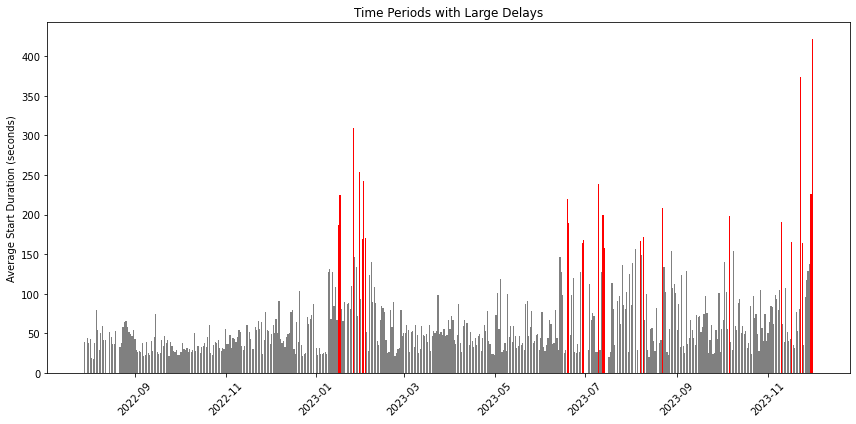

In [20]:
plt.figure(figsize=(12, 6))

# Bar plot for time periods with large delays
plt.bar(time_period_delays['time_period'], time_period_delays['start_duration'], color='gray')
plt.title('Time Periods with Large Delays')
plt.ylabel('Average Start Duration (seconds)')

# Highlighting the periods above the threshold
threshold_time = time_period_delays['start_duration'].quantile(0.95)
above_threshold = time_period_delays[time_period_delays['start_duration'] > threshold_time]
plt.bar(above_threshold['time_period'], above_threshold['start_duration'], color='red')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [21]:
start_times['time_stamp'] = pd.to_datetime(start_times['time_stamp'])

/tmp/ipykernel_1066/1126516375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_delays_periods['time_period'] = large_delays_periods['time_period'].dt.to_timestamp()


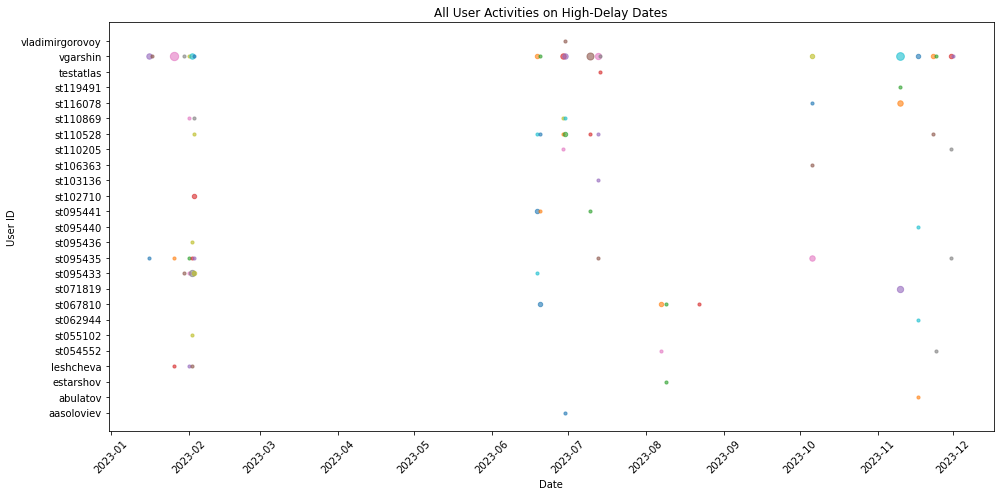

In [22]:
large_delays_periods['time_period'] = large_delays_periods['time_period'].dt.to_timestamp()
high_delay_dates = large_delays_periods['time_period'].dt.date

start_times['time_stamp'] = pd.to_datetime(start_times['time_stamp'])
start_times['date'] = start_times['time_stamp'].dt.date

# Filter the start_times DataFrame to include all user activities on high-delay dates
all_user_activities_on_high_delay = start_times[start_times['date'].isin(high_delay_dates)]

# Aggregate the activity counts by user ID and date
activity_counts = all_user_activities_on_high_delay.groupby(['user_id', 'date']).size().reset_index(name='activity_count')

# Plotting the scatter plot with the date on the x-axis and user_id on the y-axis
plt.figure(figsize=(14, 7))
for _, row in activity_counts.iterrows():
    plt.scatter(row['date'], row['user_id'], s=row['activity_count']*10, alpha=0.6)  # Scale point size for visibility

plt.title('All User Activities on High-Delay Dates')
plt.xlabel('Date')
plt.ylabel('User ID')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


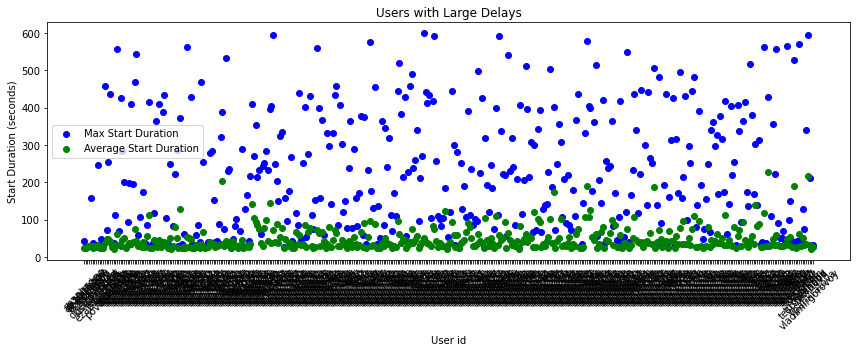

In [23]:
plt.figure(figsize=(12, 5))

plt.scatter(user_delays.index, user_delays['max'], color='blue', label='Max Start Duration')
plt.scatter(user_delays.index, user_delays['mean'], color='green', label='Average Start Duration')

plt.title('Users with Large Delays')
plt.xlabel('User id')
plt.ylabel('Start Duration (seconds)')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [24]:
above_threshold['time_period'] = pd.to_datetime(above_threshold['time_period'])

start_times['date'] = start_times['time_stamp'].dt.date
start_times['hour'] = start_times['time_stamp'].dt.hour
start_times['day_of_week'] = start_times['time_stamp'].dt.day_name()

high_delay_times = start_times[start_times['date'].isin(above_threshold['time_period'].dt.date)]
grouped_delays = high_delay_times.groupby(['day_of_week', 'hour'])['start_duration'].mean().unstack()

/tmp/ipykernel_1066/2758911113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  above_threshold['time_period'] = pd.to_datetime(above_threshold['time_period'])


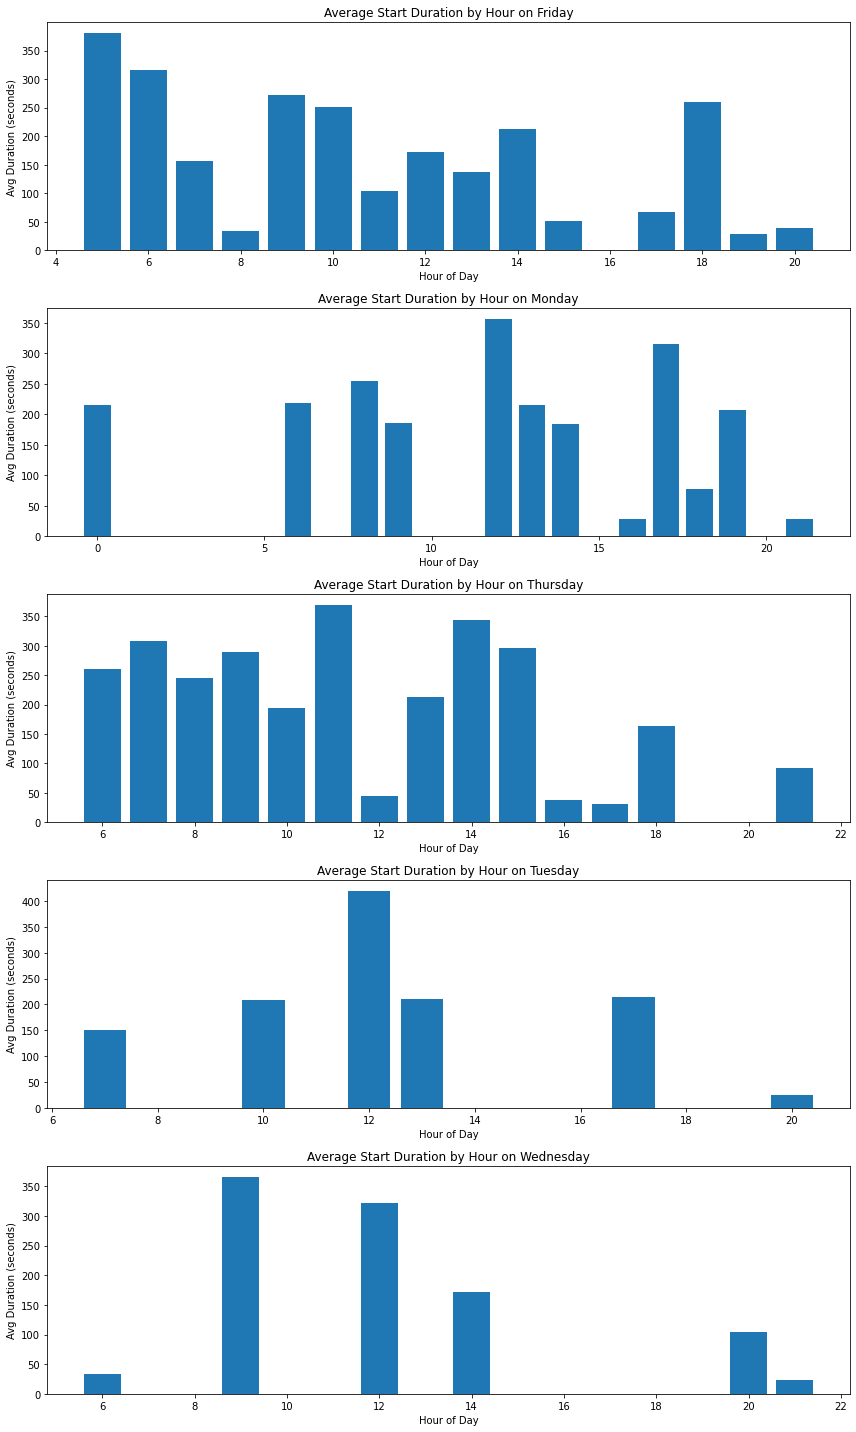

In [25]:
fig, axs = plt.subplots(len(grouped_delays.index), 1, figsize=(12, 20))

for i, day in enumerate(grouped_delays.index):
    axs[i].bar(grouped_delays.columns, grouped_delays.loc[day])
    axs[i].set_title(f'Average Start Duration by Hour on {day}')
    axs[i].set_ylabel('Avg Duration (seconds)')
    axs[i].set_xlabel('Hour of Day')

plt.tight_layout()
plt.show()

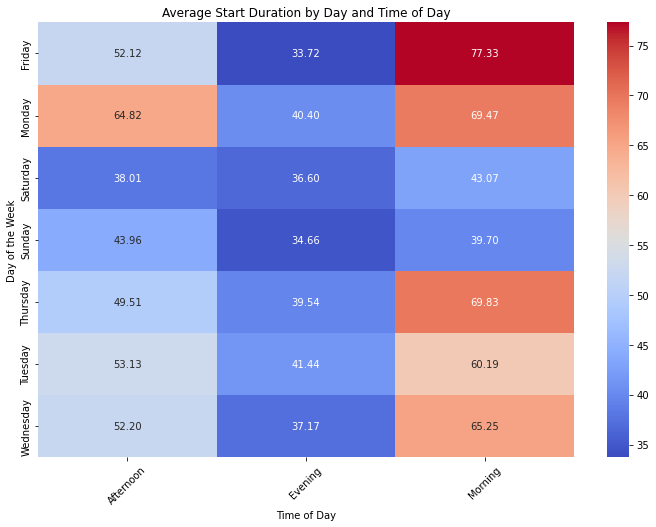

In [26]:
start_times['time_stamp'] = pd.to_datetime(start_times['time_stamp'])

start_times['day_of_week'] = start_times['time_stamp'].dt.day_name()
start_times['hour_of_day'] = start_times['time_stamp'].dt.hour

def define_time_of_day(hour):
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

start_times['time_of_day'] = start_times['hour_of_day'].apply(define_time_of_day)
delays_by_day_time = start_times.groupby(['day_of_week', 'time_of_day'])['start_duration'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(delays_by_day_time, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Start Duration by Day and Time of Day')
plt.ylabel('Day of the Week')
plt.xlabel('Time of Day')
plt.xticks(rotation=45)
plt.show()

In [27]:
start_times['time_stamp'] = pd.to_datetime(start_times['time_stamp'])
morning_start = pd.to_datetime('00:00:00').time()
morning_end = pd.to_datetime('12:00:00').time()
morning_activities = start_times[(start_times['time_stamp'].dt.time >= morning_start) &
                                 (start_times['time_stamp'].dt.time < morning_end)]
user_morning_activity_counts = morning_activities['user_id'].value_counts()
user_morning_activity_counts_df = user_morning_activity_counts.reset_index()
user_morning_activity_counts_df.columns = ['user_id', 'morning_activity_count']

print(user_morning_activity_counts_df)

       user_id  morning_activity_count
0     vgarshin                     347
1     st110205                     115
2     st110528                     113
3     st095433                      83
4     st110923                      77
..         ...                     ...
408  ab2205109                       1
409   st110160                       1
410   st101771                       1
411   st105929                       1
412   st116049                       1

[413 rows x 2 columns]


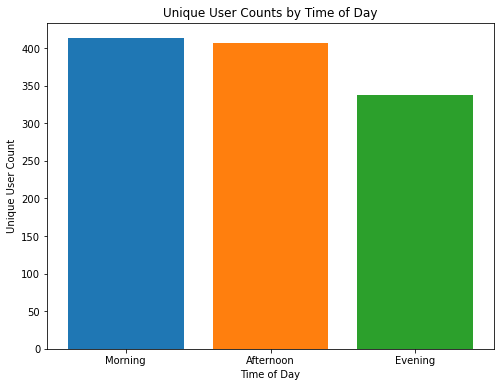

In [29]:
morning_activities = start_times[start_times['time_stamp'].dt.time.between(morning_start, morning_end)]
afternoon_activities = start_times[start_times['time_stamp'].dt.time.between(afternoon_start, afternoon_end)]
evening_activities = start_times[start_times['time_stamp'].dt.time.between(evening_start, evening_end)]

morning_user_count = morning_activities['user_id'].nunique()
afternoon_user_count = afternoon_activities['user_id'].nunique()
evening_user_count = evening_activities['user_id'].nunique()

times_of_day = ['Morning', 'Afternoon', 'Evening']
user_counts = [morning_user_count, afternoon_user_count, evening_user_count]

plt.figure(figsize=(8, 6))
plt.bar(times_of_day, user_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Unique User Counts by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Unique User Count')
plt.show()

In [30]:
morning_user_count = morning_activities['user_id'].nunique()
afternoon_user_count = afternoon_activities['user_id'].nunique()
evening_user_count = evening_activities['user_id'].nunique()

print(f'Morning unique user count: {morning_user_count}')
print(f'Afternoon unique user count: {afternoon_user_count}')
print(f'Evening unique user count: {evening_user_count}')

Morning unique user count: 413
Afternoon unique user count: 407
Evening unique user count: 338


/tmp/ipykernel_1066/2542911911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs['time_stamp'] = pd.to_datetime(logs['time_stamp'])


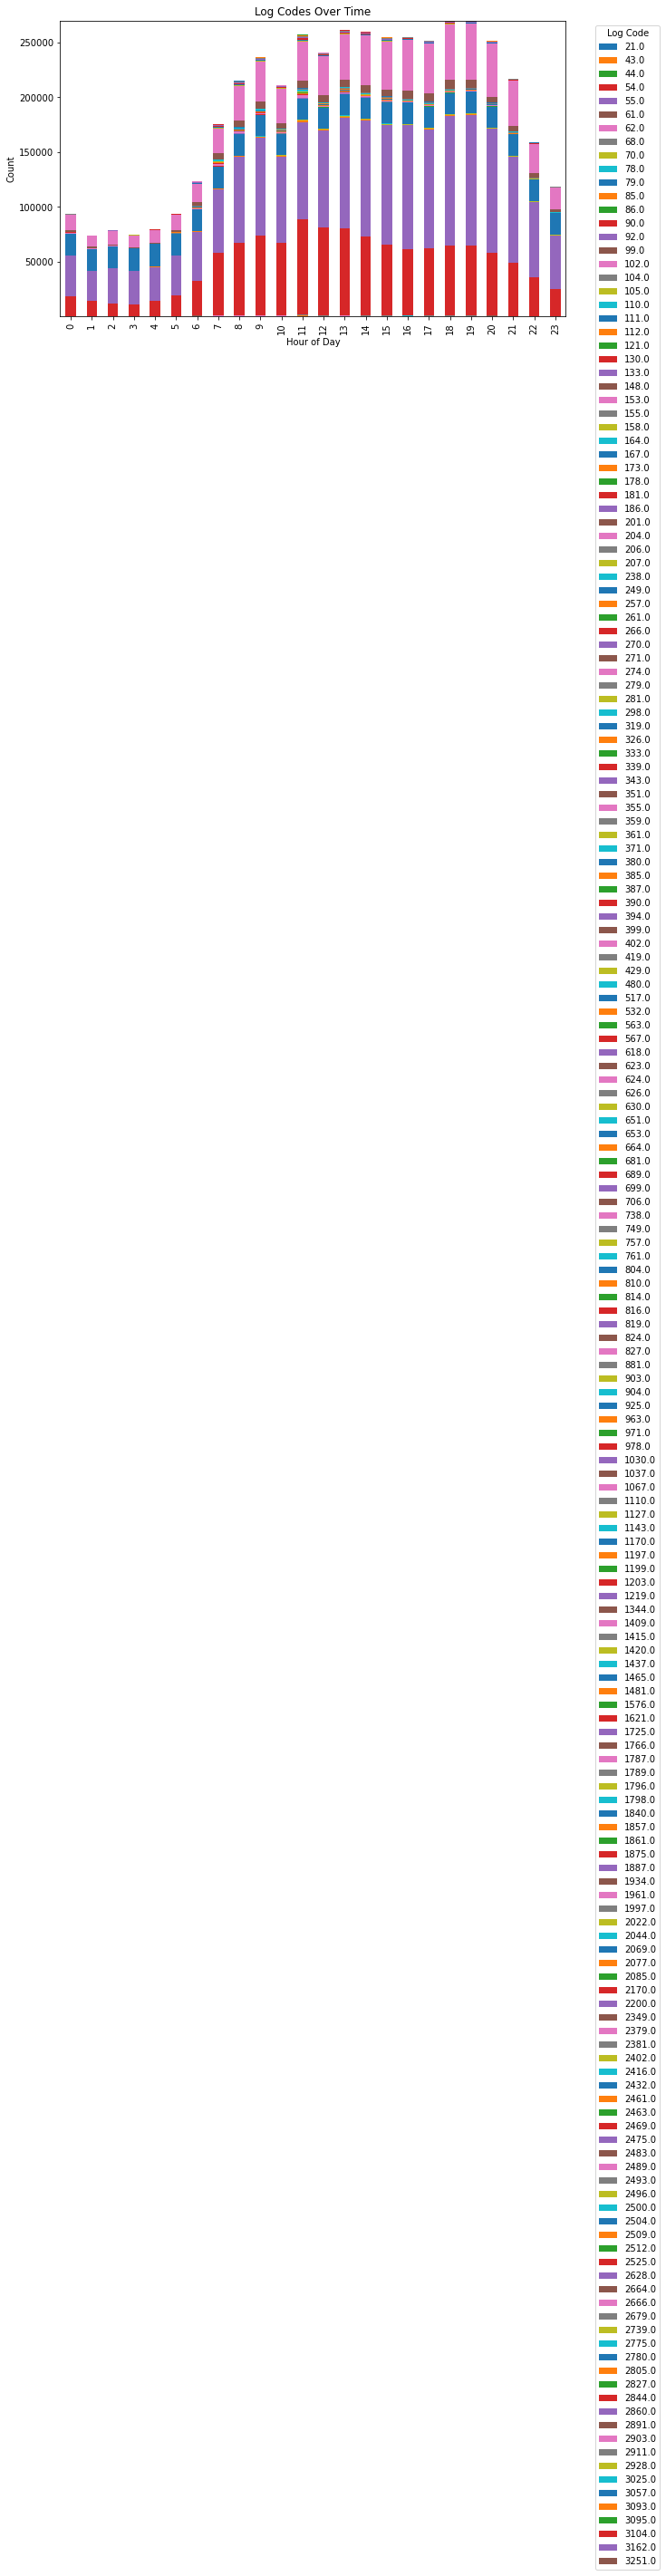

In [31]:
logs['time_stamp'] = pd.to_datetime(logs['time_stamp'])
hourly_log_code_counts = logs.groupby([logs['time_stamp'].dt.hour, 'log_code']).size().unstack(fill_value=0)
hourly_log_code_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Log Codes Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(24), range(24))
plt.legend(title='Log Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [45]:
log_codes_to_check = logs['log_code'].value_counts()
print(log_codes_to_check)

186.0     1824372
181.0     1180212
1409.0     738256
319.0      472644
1344.0     115559
           ...   
881.0           1
2860.0          1
699.0           1
1127.0          1
326.0           1
Name: log_code, Length: 186, dtype: int64


In [46]:
log_msgs_dict = {}
for code in log_codes_to_check.index:
    log_msg = logs[logs['log_code'] == code]['log_msg'].values[0]
    log_msgs_dict[code] = log_msg

for code, msg in log_msgs_dict.items():
    print(f"Log Code: {code}, Log Message: {msg}")

Log Code: 186.0, Log Message: 302 GET /user/st081184/api/kernels/cea7d019-381e-42fb-ab4e-d91e6ae4147f?1700417084895 -> /hub/user/st081184/api/kernels/cea7d019-381e-42fb-ab4e-d91e6ae4147f?1700417084895 (@10.129.0.17) 0.90ms
Log Code: 181.0, Log Message: 302 GET /user/st095441/api/contents/__VK/model_try1.ipynb?content=0&_=1680436304039 -> /hub/user/st095441/api/contents/__VK/model_try1.ipynb?content=0&_=1680436304039 (@10.129.0.3) 0.82ms
Log Code: 1409.0, Log Message: Failing suspected API request to not-running server: /hub/user/st081184/api/kernels/cea7d019-381e-42fb-ab4e-d91e6ae4147f
Log Code: 319.0, Log Message: Checking routes
Log Code: 1344.0, Log Message: Failing suspected API request to not-running server: /hub/user/st108692/api/sessions
Log Code: 402.0, Log Message: st102717 is pending spawn
Log Code: 1997.0, Log Message: Deleting pod jupyter-st109895
Log Code: 1796.0, Log Message: 404 GET /hub/user/st081184/api/kernels/a6262d98-6451-4b6e-9249-9aae6af49223?1700406659120 (10.112

   #### Error message
    266: "Resource Monitoring Failure",
    390: "Invalid Cookie Token",
    689: "Pod Startup Timeout",
    978: "Continuous Server Startup Failures",
    1030: "Continuous Server Startup Failures, Approaching Abort Threshold",
    1219: "Unhandled Exception in Error Processing",
    699: "Failed Server Cleanup Operation",
    819: "Data Format Error",
    1409.0: "API request sent to a non-functioning server.",
    1796.0: "Resource cannot be accessed or does not exist.",
    804.0: "The requested operation is out of authorized scope.",
    1787.0: "The request contains invalid Unicode characters.",
    630.0: "Server connection failed.",
    680.0: "Server startup timeout.",
    1789.0: "Uncaught exception in OAuth callback processing."

In [61]:
outliers['date'] = pd.to_datetime(outliers['date'])

/tmp/ipykernel_1066/977736187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['date'] = pd.to_datetime(outliers['date'])


/tmp/ipykernel_1066/3586711890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['month'] = outliers['date'].dt.month
/tmp/ipykernel_1066/3586711890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['day'] = outliers['date'].dt.day


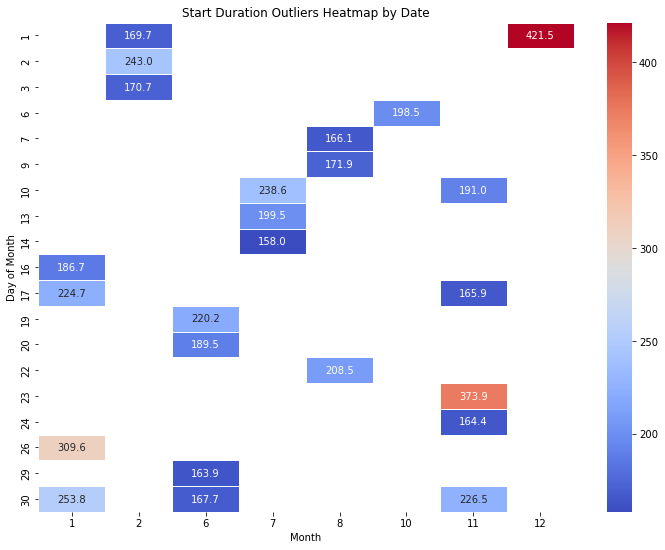

In [62]:
outliers['month'] = outliers['date'].dt.month
outliers['day'] = outliers['date'].dt.day

pivot_table = outliers.pivot("day", "month", "start_duration")


plt.figure(figsize=(12, 9))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)
plt.title('Start Duration Outliers Heatmap by Date')
plt.ylabel('Day of Month')
plt.xlabel('Month')
plt.show()